# **Finetune LLMs to Predict Human Preference using Chatbot Arena conversations**
- This notebook contain a solution for the LLM Classification Finetuning on Kaggle

**Main objective:** Predict which responses users will prefer in a head-to-head battle between chatbots powered by large language models(LLMs).

The LLM Classification Finetuning competition challenges participants to predict user preferences between responses generated by different large language models (LLMs). The dataset comprises conversations from the Chatbot Arena, where users compare responses from two anonymous LLMs and select their preferred answer. The objective is to develop a model that accurately forecasts which response a user would favor in these head-to-head comparisons.





In [28]:

import numpy as np # linear algebra
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack





In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.Import the data**

In [30]:
# Read the dataset
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

In [31]:
submission

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


In [32]:
train.head(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0


In [33]:
test

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes


In [35]:
print(f"train data shape: {train.shape}")
print(f"test data shape: {test.shape}")
print(f"sample_submission data shape: {submission.shape}")

train data shape: (57477, 9)
test data shape: (3, 4)
sample_submission data shape: (3, 4)



**In the context of large language models (LLMs) and machine learning, a prompt refers to the input or instruction given to the model to generate a response or perform a task. It is the text or query that is provided to the model, which influences the generated output**

The prompt could be a question, statement, or instruction.
The response would be the model's output based on that prompt.


In [36]:
print(test['prompt'][0])
print(test["response_a"][0])
print(test["response_b"][0])


["I have three oranges today, I ate an orange yesterday. How many oranges do I have?"]
["You have two oranges today."]
["You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today."]


**Lets generate a word cloud : A word cloud is a visual representation (image) of word data. In other words, it is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it's mentioned within a given text and the more important it is**

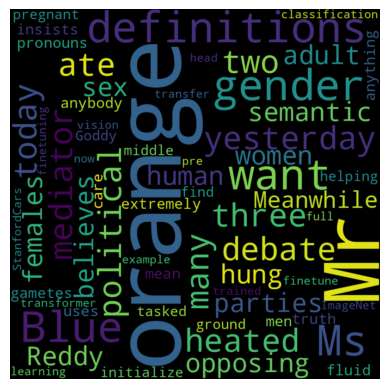

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(width=800, height=800).generate(' '.join(test['prompt'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **2.Data Cleaning & Preparing


**After laoding the data we can clean it , ts the process of identifying and correcting or removing errors, inconsistencies, and inaccuracies in a dataset to ensure its quality and reliability.**

In [38]:
#checking null or missing data
train.isnull()
test.isnull()
submission.isnull()

,id,winner_model_a,winner_model_b,winner_tie
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False


In [39]:
#Check for duplicate data
print(test.duplicated().sum())
print(train.duplicated().sum())
print(submission.duplicated().sum())

0
0
0


In [40]:
#check for duplicate id's
total_id = len(train["id"])
total_unique_id = len(train["id"].unique())

print("Total number of 'id' duplicates:")
print(total_id - total_unique_id)

Total number of 'id' duplicates:
0


# Features and Labels

We need to processes the  dataset to determine the winner among three possible outcomes:
- `winner_model_a`
- `winner_model_b`
-  `winner_tie`.
  So we define a function, `which_winner`, to assign a numerical value to each outcome. If `winner_model_a` is 1, the function returns 0 to indicate Model A is the winner; if `winner_model_b` is 1, it returns 1 for Model B as the winner; and if `winner_tie` is 1, it returns 2 to indicate a tie.
--> This function is applied row by row to the , and the results are stored in a new column named `winner`.
--> Next, the `winner` column is converted into a string-based label, `winner_model`, where numerical values are mapped to meaningful descriptions: `0` is converted to "model a," `1` to "model b," and `2` to "winner tie."
  **This will help simplifying the representation of the target variable Y .**

model winner: winner_model
model a       20064
model b       19652
winner tie    17761
Name: count, dtype: int64
-----
Matplotlib barchart, model winner:


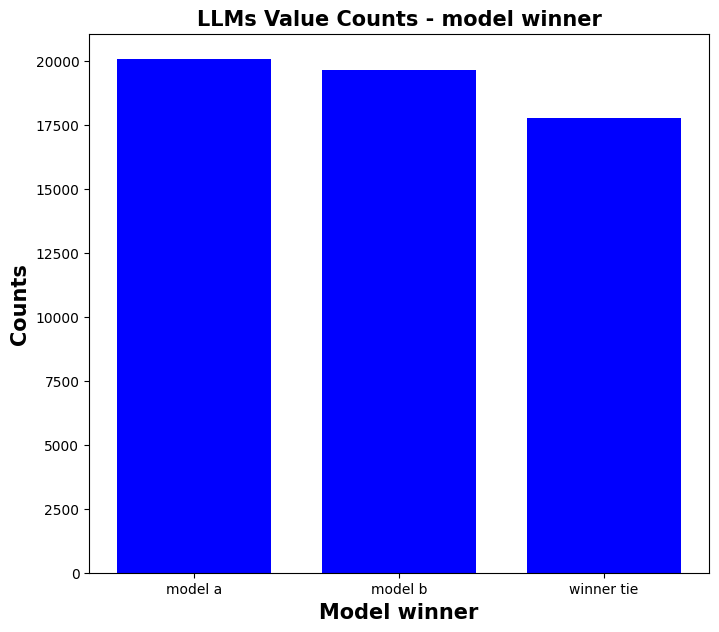

In [41]:
#barchart - model winner: winner model a, winner model b or winner tie
def which_winner(value):
    if  value["winner_model_a"] == 1:
         #winner model a
         value["winner_model_b"] = 0
         value["winner_tie"] = 0
         return 0
    elif value["winner_model_b"] == 1:
         #winner model b
         return 1
    elif value["winner_tie"] == 1:
         #winner tie
         return 2
    return None

train["winner"] = train.apply(which_winner, axis=1)

train["winner_model"] = train["winner"].astype(str)
train.loc[train["winner_model"] == "0", "winner_model"] = "model a"
train.loc[train["winner_model"] == "1", "winner_model"] = "model b"
train.loc[train["winner_model"] == "2", "winner_model"] = "winner tie"

result_model_winner = train["winner_model"].value_counts()
print("model winner:", result_model_winner)

print("-----")
print("Matplotlib barchart, model winner:")

barWidth = 0.75
plt.figure(figsize=(8, 7))
plt.bar(result_model_winner.index, result_model_winner.values, barWidth, color='b')
plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('Model winner', fontweight ='bold', fontsize = 15)
plt.title('LLMs Value Counts - model winner', fontweight ='bold', fontsize = 15)
plt.show()

In [42]:

train

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,winner_model
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,model a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,model b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,winner tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,model a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,model b
...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,0,model a
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,0,model a
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,0,model a
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1,model b



For the train_X, it should consist of the input data that our model will use to make predictions. In this case  the features will likely involve the prompt and responses.
- For example:
--Prompt: This is the user's query or instruction that needs to be processed.
--Response Pair: The two responses from the two models that need to be compared (Response a and Response b).
**In this case we gonna use BERT : we will provide  both Prompt + Response 1 and Prompt + Response 2 as separate pairs to the model.**

   **Why Use BERT for Features?**
BERT (Bidirectional Encoder Representations from Transformers) generates high-quality, contextual embeddings for textual data. These capture the meaning of sentences and words, making them ideal for tasks that require understanding the relationships between text inputs, such as comparing model outputs or predicting labels.AssertionError


In [27]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset

# Define the dataset class for batching
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to process BERT embeddings with batching
def extract_bert_embeddings(texts, tokenizer, model, batch_size=16, max_length=128, device="cuda"):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] embeddings
            all_embeddings.append(cls_embeddings.cpu())  # Store results on CPU to save GPU memory

    return torch.cat(all_embeddings, dim=0)

# Load DistilBERT tokenizer and model for faster processing
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = BertModel.from_pretrained('distilbert-base-uncased').to("cuda")

# Combine prompt and responses
train['prompt_response_a'] = train['prompt'] + " [SEP] " + train['response_a']
train['prompt_response_b'] = train['prompt'] + " [SEP] " + train['response_b']

# Extract embeddings with optimized batching
batch_size = 16  # Adjust based on your system's memory
embeddings_a = extract_bert_embeddings(
    list(train['prompt_response_a']), tokenizer, bert_model, batch_size=batch_size, device="cuda"
)
embeddings_b = extract_bert_embeddings(
    list(train['prompt_response_b']), tokenizer, bert_model, batch_size=batch_size, device="cuda"
)

print("Embeddings for prompt_response_a:", embeddings_a.shape)
print("Embeddings for prompt_response_b:", embeddings_b.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.l

Embeddings for prompt_response_a: torch.Size([57477, 768])
Embeddings for prompt_response_b: torch.Size([57477, 768])


**Step 3: Combine the Embeddings**
Once we have embeddings for both prompt + response_a and prompt + response_b, combine them to form your feature vector (X):
-Concatenate the embeddings: [CLS_A] + [CLS_B]
-Calculate the difference: [CLS_A] - [CLS_B]
-Measure similarity: Cosine similarity or dot product.

In [43]:
combined_features = torch.cat((embeddings_a, embeddings_b), dim=1)
combined_features = embeddings_a - embeddings_b

cosine_sim = F.cosine_similarity(embeddings_a, embeddings_b, dim=1)


In [44]:
train

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,winner_model
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,model a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,model b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,winner tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,model a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,model b
...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,0,model a
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,0,model a
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,0,model a
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1,model b


In [45]:
# the prediction target
train_y = train["winner"].values

In [52]:
train_X = torch.cat((embeddings_a, embeddings_b), dim=1)
train_X

tensor([[-0.9496, -0.0623,  0.5081,  ..., -1.0599, -2.0081, -0.5427],
        [-0.9773,  0.0145,  0.3722,  ..., -1.0747, -2.0810, -0.6732],
        [-0.9832, -0.1170,  0.4461,  ..., -1.0094, -1.8610, -0.6401],
        ...,
        [-0.9249, -0.0795,  0.3063,  ..., -1.1780, -2.0190, -0.5898],
        [-1.0133, -0.0889,  0.5273,  ..., -1.1401, -1.9209, -0.5948],
        [-1.0904, -0.1511,  0.3475,  ..., -0.8642, -1.7983, -0.4204]])

# 3. Model Selection and Training¶


In [55]:
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report

#start time to calculate the execution time
start_time = datetime.now()

print("Use logistic regression")
#Apply the Logistic Regression
model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='saga')
model.fit(train_X, train_y)
#end time
end_time = datetime.now()
#calculate the execution time
execution_time = (end_time - start_time).total_seconds()
print(f"The execution time is : {execution_time} secondes")


# Split into validation and training data
train_X_train, train_X_val, train_y_train, train_y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

# Record start time to calculate the execution time
start = datetime.now()

# Make predictions on the validation set
value_y_predict = model.predict(train_X_val)
print('Model predicted values:', value_y_predict)
print('True values:', train_y_val)

# Predicted probabilities
value_y_probabilities = model.predict_proba(train_X_val)
print('Model prediction probabilities (class-wise):\n', value_y_probabilities)

# Model accuracy
score = model.score(train_X_val, train_y_val)
print('The Model Accuracy Score:', score)

# Confusion matrix
conf_matrix = confusion_matrix(train_y_val, value_y_predict)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
report = classification_report(train_y_val, value_y_predict)  # Arguments fixed
print("Classification Report:\n", report)



Use logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The execution time is : 1106.988129 secondes
Model predicted values: [0 0 0 ... 1 1 0]
True values: [0 0 2 ... 1 0 0]
Model prediction probabilities (class-wise):
 [[0.52628017 0.31671134 0.15700849]
 [0.34928016 0.33504054 0.3156793 ]
 [0.34983302 0.31856585 0.33160113]
 ...
 [0.17728813 0.53359054 0.28912134]
 [0.35720972 0.36081899 0.28197128]
 [0.4071325  0.29011357 0.30275393]]
The Model Accuracy Score: 0.4619867780097425
Confusion Matrix:
 [[2155 1174  701]
 [1288 1949  692]
 [1235 1095 1207]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.53      0.49      4030
           1       0.46      0.50      0.48      3929
           2       0.46      0.34      0.39      3537

    accuracy                           0.46     11496
   macro avg       0.46      0.46      0.46     11496
weighted avg       0.46      0.46      0.46     11496



In [57]:

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(train_y_val, value_y_predict))


Accuracy: 0.4619867780097425


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Train an SVM classifier
svm = SVC(kernel="linear", C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))